In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [3]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [4]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [5]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [6]:
#clean_data = clean_data.drop('Unnamed: 0', axis=1)
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [7]:
print(rel.feature_importances_)

[0.13682166 0.4912846  0.27387864 0.0980151 ]


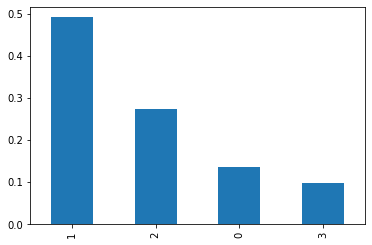

In [8]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [9]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [10]:
ordered_f.head(10)

1    0.360139
2    0.306665
0    0.060894
3    0.000000
dtype: float64

In [11]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

#x_train, x_test, y_train, y_test = train_test_split(x, cat, test_size=test_ratio, random_state=seed, stratify=cat)

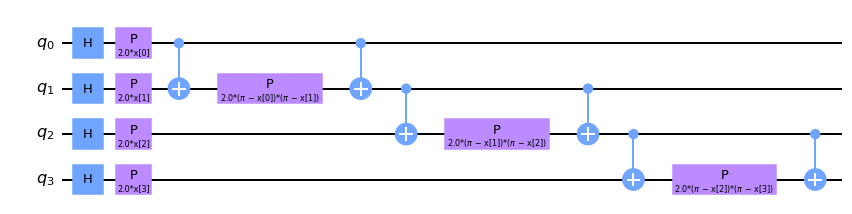

In [12]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = PauliFeatureMap(feature_dimension=feature_dim, reps=emb_layer, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

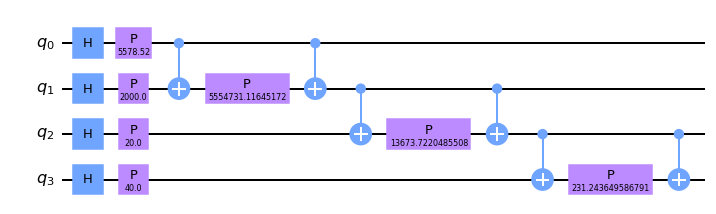

In [13]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [14]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

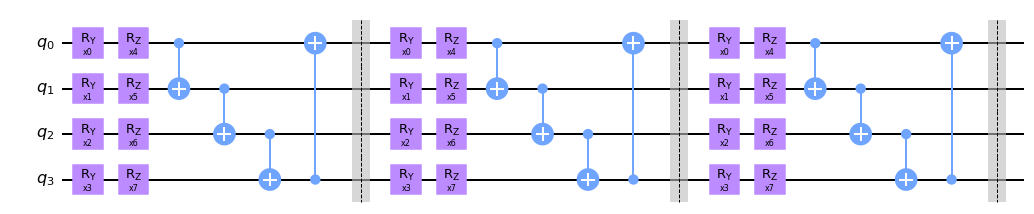

In [15]:
layer = 3
np.random.seed(seed)
nb_w = 8
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

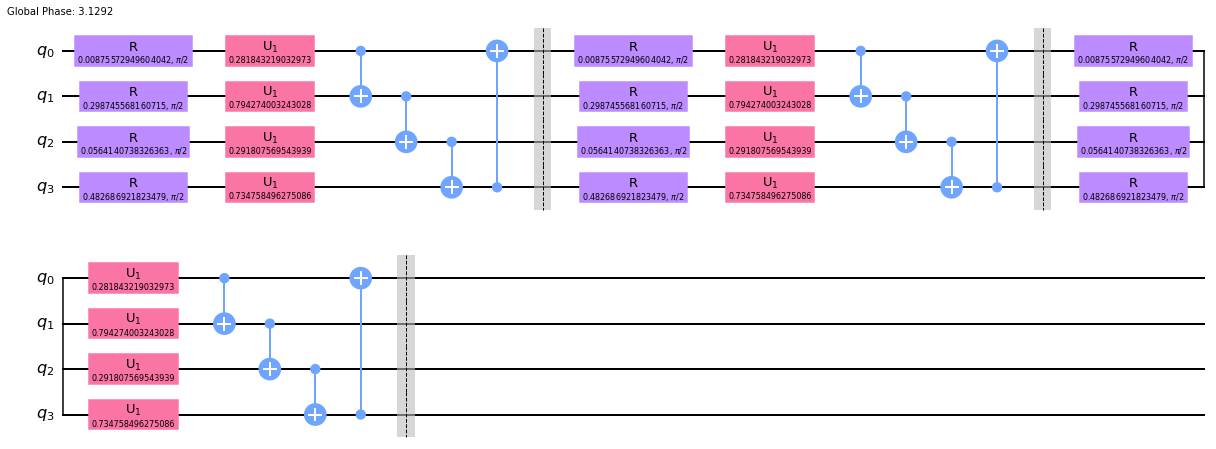

In [16]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

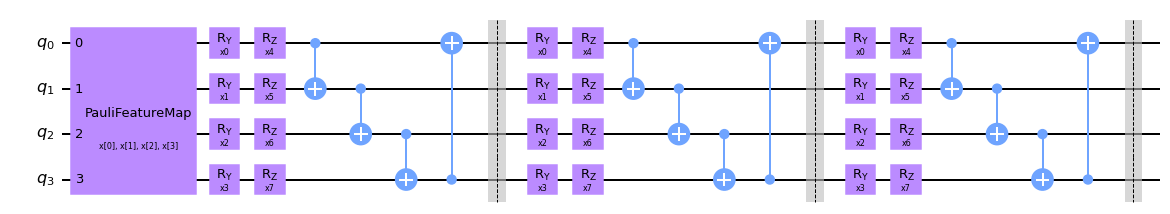

In [17]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [18]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [19]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [20]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [21]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.54785156, 0.45214844]])

In [22]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.06689453,  0.06884766,  0.41943359, -0.05786133,
          0.05419922,  0.1105957 , -0.03125   , -0.08032227],
        [-0.06689453, -0.06884766, -0.41943359,  0.05786133,
         -0.05419922, -0.1105957 ,  0.03125   ,  0.08032227]]])

In [23]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [24]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [25]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 303.63835683908087
6 - 307.730216546269
9 - 303.6554357062365
12 - 304.10526275091127
15 - 302.76642421500185
18 - 301.8883702216296
21 - 300.84680967223596
24 - 300.9100157441417
27 - 300.93882052441666
30 - 299.9655386623332
33 - 299.18813825714466
36 - 298.9652369605226
39 - 298.6137883755009
42 - 297.57863984005024
45 - 297.5699041382675
48 - 298.266963654272
51 - 298.1906943274686
54 - 298.20371677680595
57 - 296.25426073361405
60 - 296.0829460334679
63 - 297.049682181065
66 - 295.9706799189889
69 - 296.46131368890565
72 - 295.8884497558267
75 - 295.9275781408326
78 - 295.35131550320176
81 - 295.61270224749916
84 - 294.82410962351247
87 - 294.46258624467424
90 - 294.0717100649056
93 - 293.6414687619316
96 - 292.6745345146064
99 - 292.928592839268
102 - 291.5398287455696
105 - 291.37708356288124
108 - 291.51689311954556
111 - 291.37085538249164
114 - 291.90816279465713
117 - 292.0961726936794
120 - 291.87269931168885
123 - 291.82643388946
126 - 291.65997803789736
129 - 291.3259

In [26]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.5966666666666667
Score on the test set 0.525


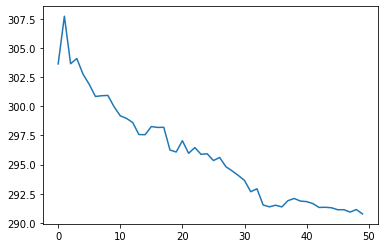

In [27]:
plt.plot(loss_recorder)

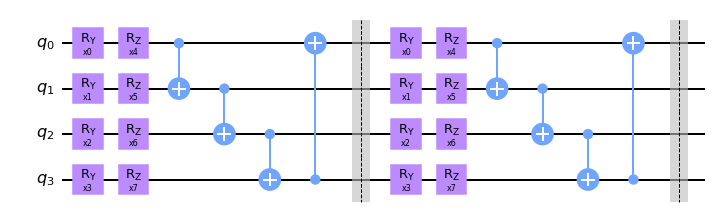

In [28]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

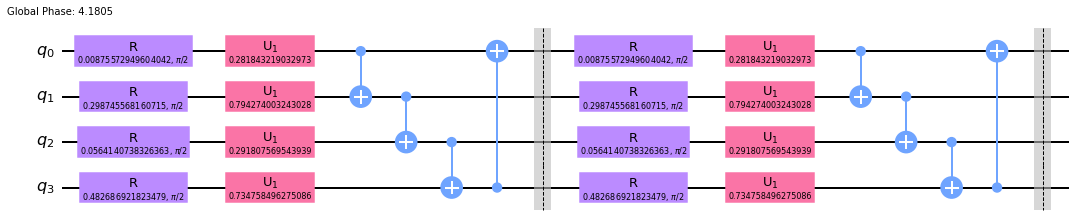

In [29]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

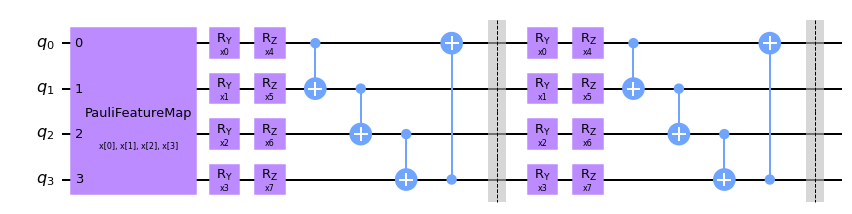

In [30]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [31]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [32]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.59863281, 0.40136719]])

In [33]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00073242,  0.28881836, -0.00219727, -0.11694336,
         -0.03076172,  0.10058594,  0.04052734, -0.03149414],
        [-0.00073242, -0.28881836,  0.00219727,  0.11694336,
          0.03076172, -0.10058594, -0.04052734,  0.03149414]]])

In [34]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 300.29263036885425
6 - 317.8725846898362
9 - 305.05442315612595
12 - 307.4740247535292
15 - 306.3811713417737
18 - 308.23395815966524
21 - 308.55572155842276
24 - 299.3005206156862
27 - 300.26630272635356
30 - 320.98054538216695
33 - 318.6973587451355
36 - 318.2373380744098
39 - 323.5005516324344
42 - 311.2863261409319
45 - 298.7637501091599
48 - 298.51485253199536
51 - 300.34998468798085
54 - 300.2158768472967
57 - 298.2236964793178
60 - 297.2739003456944
63 - 296.18931161756143
66 - 295.71875465298126
69 - 294.2029773301448
72 - 292.37375459579494
75 - 290.8097173040653
78 - 290.7575338559267
81 - 290.9857365801697
84 - 290.6732788810619
87 - 290.6586660468303
90 - 290.9392219226818
93 - 290.7643867133438
96 - 290.56828088671637
99 - 289.81205076880474
102 - 289.3480915605134
105 - 289.7259058217417
108 - 289.71049462533193
111 - 289.84684594376415
114 - 289.7977412725887
117 - 289.3395699453703
120 - 289.41529497617597
123 - 289.6395427753141
126 - 289.5672084275791
129 - 288.59

In [35]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.5966666666666667
Score on the test set 0.5833333333333334


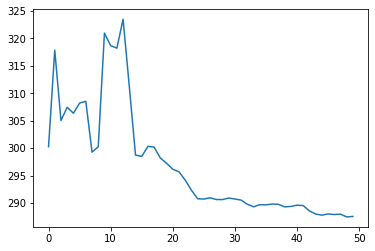

In [36]:
plt.plot(loss_recorder)

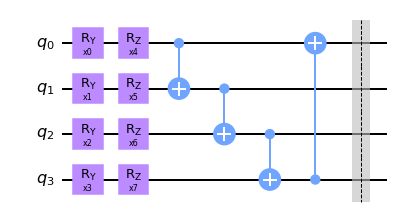

In [37]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

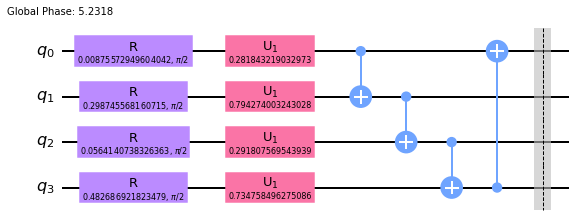

In [38]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

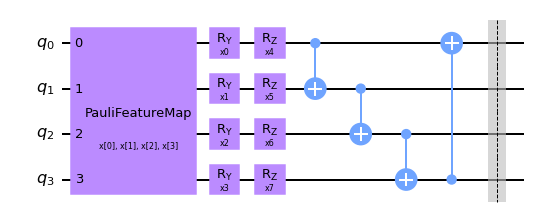

In [39]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [40]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [41]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50341797, 0.49658203]])

In [42]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00219727,  0.02929687, -0.06469727,  0.03979492,
          0.0078125 , -0.01708984, -0.00366211,  0.00244141],
        [-0.00219727, -0.02929687,  0.06469727, -0.03979492,
         -0.0078125 ,  0.01708984,  0.00366211, -0.00244141]]])

In [43]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 299.09170615418526
6 - 300.03752595538333
9 - 296.7552651340407
12 - 296.4888378241865
15 - 296.6719615144617
18 - 296.53978458930794
21 - 296.61761149279164
24 - 296.79448079889903
27 - 296.76048395561827
30 - 296.63608804963263
33 - 296.48562562605457
36 - 296.43923439159573
39 - 296.4124215142964
42 - 296.41646736022346
45 - 296.40001209105105
48 - 296.53633166799284
51 - 296.35317426137686
54 - 296.3602389784476
57 - 296.0304791080424
60 - 296.0073452954563
63 - 296.0745013263653
66 - 296.07877384759075
69 - 296.01428021004193
72 - 296.03088911427176
75 - 296.0589829336726
78 - 296.1110890338161
81 - 296.2703736069691
84 - 296.26315477830644
87 - 296.28094942273555
90 - 296.30321607289096
93 - 296.25479238996917
96 - 296.10246005585503
99 - 296.1917784475826
102 - 296.2141086660828
105 - 296.2119541545701
108 - 296.1760385557994
111 - 296.19140638374716
114 - 296.20322528433513
117 - 296.23865979951063
120 - 296.2701910666832
123 - 296.2542807121263
126 - 296.2705547102697
129 

In [44]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.55
Score on the test set 0.5083333333333333


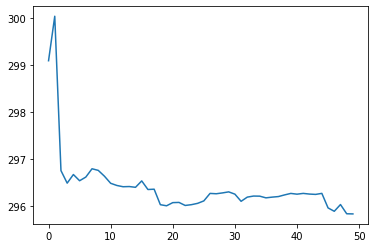

In [45]:
plt.plot(loss_recorder)